In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [12]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [15]:
@test 
def bicycle_model(curr_pose, v, delta, dt=1.0):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model

    L = 0.9 # wheel base length
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += (v/L)*np.tan(delta)*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1.11) 
Got:
    (1.0, 0.0, 1.111111111111111)


In [16]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
v = 1.0 
delta = 0.0 
straight_trajectory.append(pose)
for _ in range(steps):
   #instruction to take v, delta and compute new pose    
  pose = bicycle_model(pose,v,delta)
   # store new pose
  straight_trajectory.append(pose)
straight_trajectory = np.array(straight_trajectory)

In [17]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 1033
#fill in v and delta values
v = 1.0
delta = 0.5
circle_trajectory.append(pose)
for _ in range(steps):
    #instruction to take v, delta and compute new pose    
  pose = bicycle_model(pose,v,delta,dt=0.01)
   # store new pose
  circle_trajectory.append(pose) 
circle_trajectory = np.array(circle_trajectory)

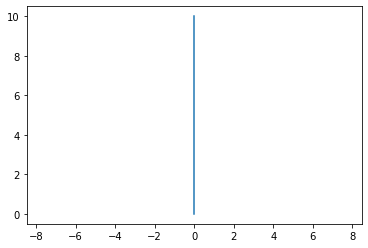

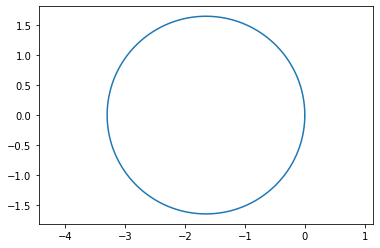

In [18]:

### Plot straight and circular trajectories
# straight line
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0],straight_trajectory[:,1])

# circle
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0],circle_trajectory[:,1])



### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [19]:
v_c = 1# m/s
delta_c = np.pi/12 # rad/s

#calculate time taken to finish a quarter turn (pi/2)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = np.ceil(np.pi/2/delta_c).astype('int')

#calculate the time taken to finish straight segments
t_straight1 = np.ceil(10/v_c).astype('int')
t_straight2 = np.ceil(5/v_c).astype('int')
t_straight3 = np.ceil(8/v_c).astype('int')
# omega array is to be padded with equivalent zeros

#t_straight1, t_straight_2, t_straight3 = 

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [35]:
def get_open_loop_commands(route, vc, deltac):
  all_delta = []
  L = 0.9 # base length
  delta = {"straight":0.0, "left":deltac, "right":-deltac}
  for manovere, command in route:
    dt_u = np.ceil(command/vc).astype('int')
    theta = np.deg2rad(command)
    theta_dot = vc*np.tan(deltac)/L
    dt_v = np.ceil(np.pi/2/theta_dot).astype('int') #(np.pi*L/2)/(vc*np.tan(deltac))
    t_cmd = dt_u if manovere == 'straight' else dt_v
    all_delta += [delta[manovere]]*t_cmd
  all_delta = np.array(all_delta)
  all_v = vc*np.ones_like(all_delta)
  return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [36]:
all_v,all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],1,np.pi/12)

In [37]:
robot_trajectory = []
pose = np.array([0, 0, np.pi/2])
robot_trajectory.append(pose)
for v, delta in zip(all_v, all_delta):
    #instruction to take v, delta and compute new pose    
  pose = bicycle_model(pose,v,delta)
   # store new pose
  robot_trajectory.append(pose)
robot_trajectory = np.array(robot_trajectory)
print(robot_trajectory)

[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
 [ 6.12323400e-17  1.00000000e+00  1.57079633e+00]
 [ 1.22464680e-16  2.00000000e+00  1.57079633e+00]
 [ 1.83697020e-16  3.00000000e+00  1.57079633e+00]
 [ 2.44929360e-16  4.00000000e+00  1.57079633e+00]
 [ 3.06161700e-16  5.00000000e+00  1.57079633e+00]
 [ 3.67394040e-16  6.00000000e+00  1.57079633e+00]
 [ 4.28626380e-16  7.00000000e+00  1.57079633e+00]
 [ 4.89858720e-16  8.00000000e+00  1.57079633e+00]
 [ 5.51091060e-16  9.00000000e+00  1.57079633e+00]
 [ 6.12323400e-16  1.00000000e+01  1.57079633e+00]
 [ 6.73555740e-16  1.10000000e+01  1.86851765e+00]
 [-2.93342540e-01  1.19560074e+01  2.16623898e+00]
 [-8.54217819e-01  1.27839077e+01  2.46396030e+00]
 [-1.63327712e+00  1.34108580e+01  2.76168163e+00]
 [-2.56197475e+00  1.37816958e+01  3.05940295e+00]
 [-3.55859908e+00  1.38637930e+01 -2.92606103e+00]
 [-4.53546191e+00  1.36499262e+01 -2.92606103e+00]
 [-5.51232475e+00  1.34360594e+01 -2.92606103e+00]
 [-6.48918759e+00  1.32221927e+

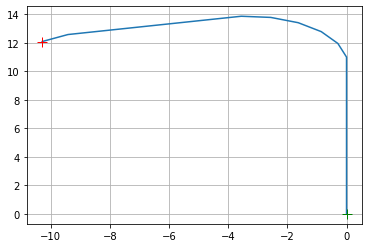

In [38]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1] )

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
xi,yi,_ = robot_trajectory[0]
xf,yf,_ = robot_trajectory[-1]
plt.plot(xi,yi,'g+',ms=10)
plt.plot(xf,yf,'r+',ms=10)


### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [39]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

How does a right turn look? 

In [40]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


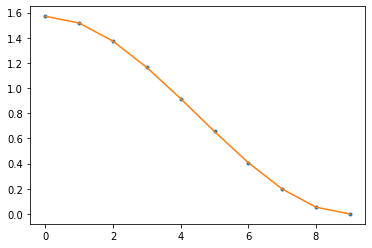

In [41]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to West)

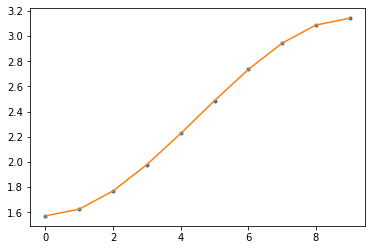

In [42]:
plt.figure()
plt.plot(poly_turn(np.pi/2,np.pi),'.')
plt.plot(poly_turn(np.pi/2,np.pi))

How does $\theta$ change when we had constant $\delta$? Plot it

We know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [53]:
route = [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
L = 0.9
v_c = 1.0
t_straight1 = np.ceil(5/v_c).astype('int')
t_straight2 = np.ceil(6/v_c).astype('int')
theta_right = poly_turn(np.pi/2,0)
theta_dot_right = np.diff(theta_right)
delta_c = theta_dot_right*L/v_c
delta_c = np.append(np.zeros(t_straight1),delta_c)
delta_c = np.append(delta_c,np.zeros(t_straight2))
theta_left = poly_turn(0,-np.pi/2)
theta_dot_left = np.diff(theta_left)
det_c = theta_left*L/v_c
delta_c = np.append(delta_c,det_c)
v_c = np.ones_like(delta_c)
pose = (0.0,0.0,np.pi/2)
robot_traj = [pose]
for v, delta in zip(v_c, delta_c):
  pose = bicycle_model(pose,v,delta)
  robot_traj.append(pose)
robot_traj = np.array(robot_traj)


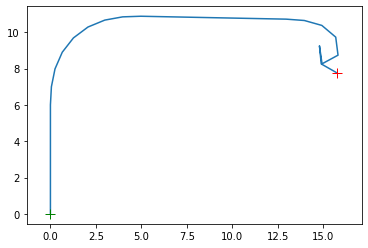

In [54]:
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(robot_traj[:,0],robot_traj[:,1])
xi,yi = robot_traj[0,0],robot_traj[0,1]
xf,yf = robot_traj[-1,0],robot_traj[-1,1]
plt.plot(xi,yi,'g+',ms=10)
plt.plot(xf,yf,'r+',ms=10)